In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob
from math import sqrt

In [2]:
def compute_stats_range(x_vals, y_vals, x_stds):
    ### computes statistic intervals given x, y and x uncertainties.
    r, p_ignore = scipy.stats.pearsonr(x_vals, y_vals)
    mue = mean_absolute_error(x_vals, y_vals)
    rmse = mean_squared_error(x_vals, y_vals)
    rho, p_ignore = scipy.stats.spearmanr(x_vals, y_vals)
    tau, p_ignore = scipy.stats.kendalltau(x_vals, y_vals)
    
 
    # compute the higher bound for x using the standard deviation:
    upper_x_vals = []
    for x, y, std in zip(x_vals, y_vals, x_stds):
        if x <= y:
            upper_x = x-std
        elif x > y:
            upper_x = x + std
        upper_x_vals.append(upper_x)

    # with this new array, compute stats side by side and subtract to get the uncertainty:
    upper_r, p_ignore = scipy.stats.pearsonr(upper_x_vals, y_vals)
    r_range = r - upper_r      

    upper_mue = mean_absolute_error(upper_x_vals, y_vals)
    mue_range = upper_mue - mue

    upper_rmse = sqrt(mean_squared_error(upper_x_vals, y_vals))
    rmse_range = upper_rmse - rmse

    upper_rho, p_ignore = scipy.stats.spearmanr(upper_x_vals, y_vals)
    rho_range = rho - upper_rho

    upper_tau, p_ignore = scipy.stats.kendalltau(upper_x_vals, y_vals)
    tau_range = tau - upper_tau

    results = [ r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range ]
   
    return results

In [3]:
def compute_stats(x_vals, y_vals):
    ### computes single-point statistic intervals
    r, p_ignore = scipy.stats.pearsonr(x_vals, y_vals)
    mue = mean_absolute_error(x_vals, y_vals)
    rmse = mean_squared_error(x_vals, y_vals)
    rho, p_ignore = scipy.stats.spearmanr(x_vals, y_vals)
    tau, p_ignore = scipy.stats.kendalltau(x_vals, y_vals)
    results = [ r, mue, rmse, rho, tau ]
   
    return results

In [4]:
# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)').sort_index()


## FreeSolv test set plot

In [5]:
# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)').sort_index()

# extract experimental and calculated hydration free energies for just the Wymer et al subset:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','experimental value (kcal/mol)']
test_calc = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','Mobley group calculated value (GAFF) (kcal/mol)']
# extract associated uncertainties:
test_exp_u = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','experimental uncertainty (kcal/mol)']
test_calc_u = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','calculated uncertainty (kcal/mol)']

# now add the six discrepant molecules to the test set:
dscrpnt_mols = ['mobley_6309289', 'mobley_3395921', 'mobley_6739648', 'mobley_2607611', 'mobley_637522', 'mobley_172879']
for mol in dscrpnt_mols:
    mol_info = freesolv_df.loc[freesolv_df.index == mol]
    test_exp = test_exp.append(mol_info['experimental value (kcal/mol)'])
    test_calc = test_calc.append(mol_info['Mobley group calculated value (GAFF) (kcal/mol)'])
    test_exp_u = test_exp_u.append(mol_info['experimental uncertainty (kcal/mol)'])
    test_calc_u = test_calc_u.append(mol_info['calculated uncertainty (kcal/mol)'])
test_exp = test_exp.sort_index()
test_calc = test_calc.sort_index()
test_exp_u = test_exp_u.sort_index()
test_calc_u = test_calc_u.sort_index()

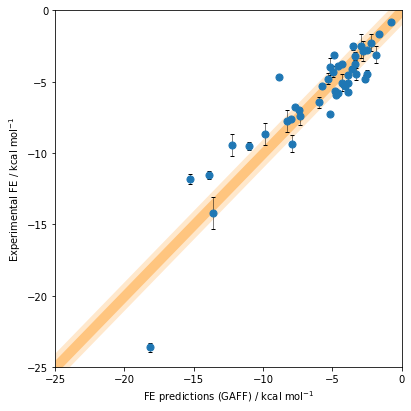

                 Value  Uncertainty
Pearson r     0.917541     0.003023
MUE           1.158723     0.036809
RMSE          2.492532    -0.883018
Spearman rho  0.865948     0.001008
Kendall tau   0.720037     0.001258
Excluding the outlier:
                 Value  Uncertainty
Pearson r     0.923217     0.002614
MUE           1.065217     0.035652
RMSE          1.898639    -0.492499
Spearman rho  0.857011     0.001075
Kendall tau   0.707588     0.001308


In [6]:



# plot the original SAMPL4 predictions:
plt.figure(figsize=(6,6))

plt.errorbar(x=test_calc, y=test_exp, 
             xerr=test_calc_u, yerr=test_exp_u, 
             ls='none', c="black", capsize=2, lw=0.5)

plt.scatter(x=test_calc, y=test_exp, s=50,zorder=100)

# some more formatting:
plt.ylim([-25,0])
plt.xlim([-25,0])
# plt.title("Wymer set FEP vs EXP")
plt.xlabel(r"FE predictions (GAFF) / kcal mol$^{-1}$")
plt.ylabel(r"Experimental FE / kcal mol$^{-1}$")
plt.fill_between(
				x=[-25, 0], 
				y2=[-24.5,0.5],
				y1=[-25.5,-0.5],
				lw=0, 
				zorder=-10,
				alpha=0.5,
				color="darkorange")
# upper bound:
plt.fill_between(
				x=[-25, 0], 
				y2=[-24,1],
				y1=[-24.5,0.5],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-25, 0], 
				y2=[-25.5,-0.5],
				y1=[-26,-1],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)

plt.rcParams.update({'font.size': 16}) 
plt.tight_layout()
plt.savefig("OUTPUTS/wymer_fepVSexp.png", dpi=300)
plt.show()
# statistics:
r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(test_calc, test_exp, test_calc_u)
statistics_wymer = {
                "Pearson r": [r, r_range],
                "MUE": [mue, mue_range],
                "RMSE" : [rmse, rmse_range],
                "Spearman rho" : [rho, rho_range],
                "Kendall tau": [tau, tau_range]        
                   }
statistics_wymer_df = pd.DataFrame.from_dict(statistics_wymer, orient="index", columns=["Value", "Uncertainty"])
print(statistics_wymer_df)
print("Excluding the outlier:")

test_calc_no = test_calc.drop(["mobley_4587267"])
test_exp_no = test_exp.drop(["mobley_4587267"])
test_calc_u_no = test_calc_u.drop(["mobley_4587267"])
r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(test_calc_no, test_exp_no, test_calc_u_no)
statistics_wymer_no = {
                "Pearson r": [r, r_range],
                "MUE": [mue, mue_range],
                "RMSE" : [rmse, rmse_range],
                "Spearman rho" : [rho, rho_range],
                "Kendall tau": [tau, tau_range]        
                   }
statistics_wymer_df_no = pd.DataFrame.from_dict(statistics_wymer_no, orient="index", columns=["Value", "Uncertainty"])
print(statistics_wymer_df_no)

^Note that the FEP predictions have very low uncertainties (~0.03 kcal/mol) and thus don't show up in the plot.

## Apply correction terms
### Load ML models while predicting on test set; take ensemble averages

In [7]:
def correctWymer(dGoffset_predictions, std_dGoffset_predictions, test_calc, test_calc_u, test_exp):
    # correct Wymer FEP predictions in SAMPL4; propagate error by multiplying dGoffset STD with FEP uncertainty.
    wymer_predictions = test_calc.values
    corrected_wymer_predictions = []

    # now correct each wymer prediction:
    for offset_pred, wymer_pred, exp in zip(dGoffset_predictions, wymer_predictions, test_exp):
        corrected = wymer_pred + offset_pred
        dGoffset_exp = exp - wymer_pred 

        corrected_wymer_predictions.append(corrected)

        
    propagated_uncertainties = []
    for ml_error, fep_error in zip(std_dGoffset_predictions, test_calc_u):
        prop_error = sqrt((ml_error**2) + (fep_error**2))
        propagated_uncertainties.append(prop_error)

    stats = compute_stats_range(corrected_wymer_predictions, test_exp, propagated_uncertainties)
    return stats, corrected_wymer_predictions, propagated_uncertainties
    

In [8]:
def loadPredictModels(model_paths, test_X, test_y, corrector=False):
    # loads a list of models (using paths), predicts on test set and generates stats for the ensemble.

    # adjust test set structure:
    test_y = [ value[0] for value in test_y.values ] 
       
    # loop over model paths, regenerate, predict:
    predictions = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)
    
    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)
    
    if corrector:
        stats, mean_predictions, std_predictions = correctWymer(mean_predictions, std_predictions, test_calc, test_calc_u, test_exp)
    elif not corrector:
        stats = compute_stats_range(mean_predictions, test_y, std_predictions)

    return stats, [mean_predictions, std_predictions]

In [9]:
datasets_dr = "./datasets/DATASETS/"
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]

statistics_collection = []
top_performers_collection = []
null_top_performers_collection = []


for ml_model in ML_models:
    
    top_performer_mue = np.inf
    null_top_performer_mue = np.inf
    
    for feature_set in feature_sets:
        # load the corresponding test set files (i.e. with the right features)
        test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()

        test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()
               
        test_X_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()
        test_y_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()
                
        # now load both the null and corrector models for this feature set:
        model_output_path = ml_model+"/output/"+feature_set
        all_trained_models = glob.glob(model_output_path+"/*.pickle")
        null_models = [model for model in all_trained_models if "null" in model]
        corrector_models = [model for model in all_trained_models if not "null" in model]
        if len(null_models) != len(corrector_models):
            print("NOT THE SAME NUMBER OF CORRECTOR AND NULL MODELS")
        # we will consider all models equal in the ensemble, so each ensemble consists of 5x10 = 50 trained models.
        
        # now for each model, load and predict; extract the necessary data:
        stats, prediction = loadPredictModels(corrector_models, test_X, test_y, corrector=True)

        if stats[1] < top_performer_mue:
            
            top_performer_mue = stats[1]
            top_performer_predictions = prediction
            top_performer_info = feature_set
        
        stats_null, prediction_null = loadPredictModels(null_models, test_X_null, test_y_null)
        if stats_null[1] < null_top_performer_mue:
            null_top_performer_mue = stats_null[1]
            null_top_performer_predictions = prediction_null
            null_top_performer_info = feature_set
            
        statistics_collection.append([ml_model, feature_set, "Corrector", stats])
        statistics_collection.append([ml_model, feature_set, "Null", stats_null])
    # now for this ML model, extract the top performer and its details:
    top_performers_collection.append([ml_model, top_performer_info, top_performer_predictions])
    null_top_performers_collection.append([ml_model, null_top_performer_info, null_top_performer_predictions])
    
# retrieve original FEP statistics to include as first row in table:
wymer_stats = np.append(statistics_wymer_df["Value"].values, statistics_wymer_df["Uncertainty"].values)

def return_merged_w_pm(mean, unc):
    # returns two numbers appended as rounded strings with a plusminus sign between.
    mean = str(round(mean, 2))
    unc = str(round(unc, 2))
    merged_vals = mean+u"\u00B1"+unc
    return merged_vals
    
    
    
stats_df = pd.DataFrame.from_dict([{
        "Model" : "FEP",
        "Featureset" : "",
        "Type" : "",
        "Pearson r" : return_merged_w_pm(wymer_stats[0], wymer_stats[5]),
        "MUE" : return_merged_w_pm(wymer_stats[1], wymer_stats[6]),
        "RMSE" : return_merged_w_pm(wymer_stats[2], wymer_stats[7]),
        "Spearman rho" : return_merged_w_pm(wymer_stats[3], wymer_stats[8]),
        "Kendall tau" : return_merged_w_pm(wymer_stats[4], wymer_stats[9]),
        "r_means" : wymer_stats[0],
        "MUE_means" : wymer_stats[1],
        "RMSE_means" : wymer_stats[2],
        "tau_means" : wymer_stats[4],
        "r_uncs" : wymer_stats[5],
        "MUE_uncs" : wymer_stats[6],
        "RMSE_uncs" : wymer_stats[7],
        "tau_uncs" : wymer_stats[9],
        
    }])           


for model in statistics_collection:
    
    model_stats_dict = {
        "Model" : model[0],
        "Featureset" : model[1],
        "Type" : model[2],
        "Pearson r" : return_merged_w_pm(model[3][0], model[3][5]),
        "MUE" : return_merged_w_pm(model[3][1], model[3][6]),
        "RMSE" : return_merged_w_pm(model[3][2], model[3][7]),
        "Spearman rho" : return_merged_w_pm(model[3][3], model[3][8]),
        "Kendall tau" : return_merged_w_pm(model[3][4], model[3][9]),
        "r_means" : model[3][0],
        "MUE_means" : model[3][1],
        "RMSE_means" : model[3][2],
        "tau_means" : model[3][4],
        "r_uncs" : model[3][5],
        "MUE_uncs" : model[3][6],
        "RMSE_uncs" : model[3][7],
        "tau_uncs" : model[3][9],
    }
    stats_df = stats_df.append(model_stats_dict, ignore_index=True)

stats_df = round(stats_df.sort_values(by=["Type", "MUE_means"]), 3)
stats_df.to_csv("OUTPUTS/SAMPL4_predictions_statistics.csv")


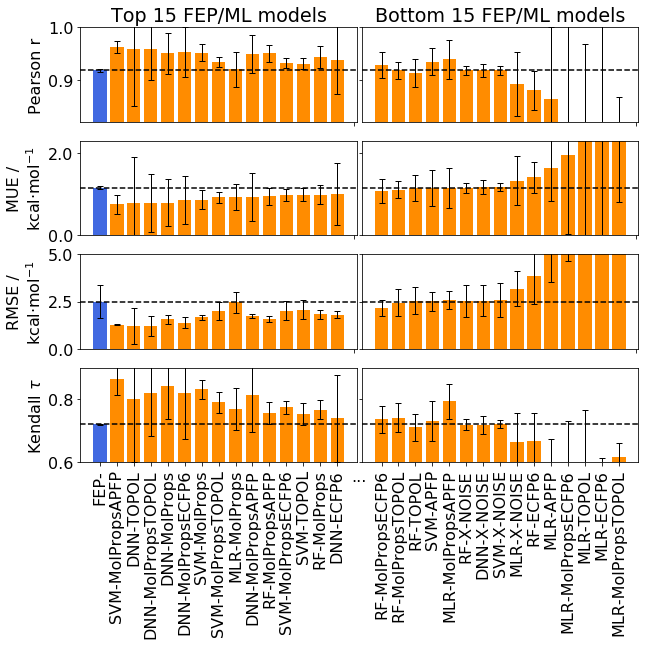

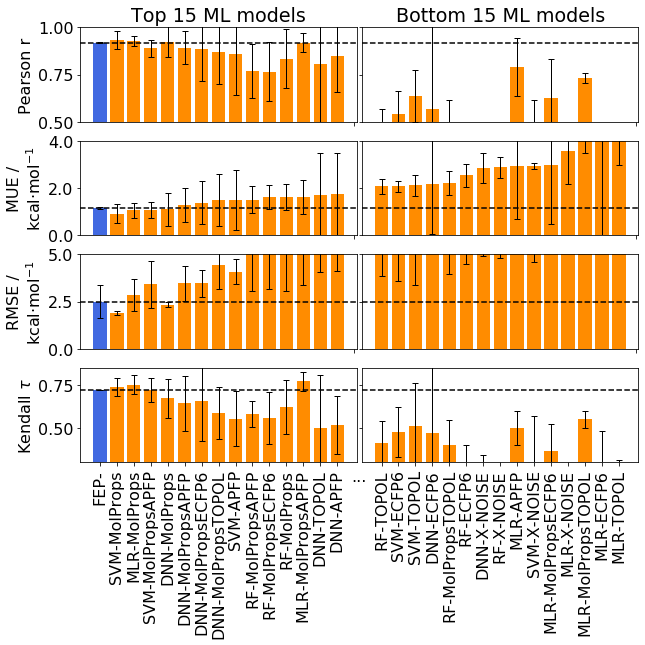

In [10]:
from matplotlib.ticker import FormatStrFormatter

# build a barplot of the above table:
num_bars_per_subplot = 30
num_top = num_bottom = int(num_bars_per_subplot/2)
# divide back into hybrid and PML dataframes:
fep_df = stats_df.loc[stats_df["Model"] == "FEP"]
fep_mean_stats = [fep_df["r_means"].values[0], fep_df["MUE_means"].values[0], fep_df["RMSE_means"].values[0], fep_df["tau_means"].values[0]]

hyb_df = stats_df.loc[stats_df["Type"] == "Corrector"]
pml_df = stats_df.loc[stats_df["Type"] == "Null"]

hyb_plot_data = pd.concat([fep_df, hyb_df], axis=0, ignore_index=True)
hyb_plot_data_top = hyb_plot_data.head(num_top)
hyb_plot_data_bottom = hyb_plot_data.tail(num_bottom)

pml_plot_data = pd.concat([fep_df, pml_df], axis=0, ignore_index=True)
pml_plot_data_top = pml_plot_data.head(num_top)
pml_plot_data_bottom = pml_plot_data.tail(num_bottom)

# define colours (we want FEP to be blue, remainders to be orange):
top_colours = ["royalblue"] + ["darkorange"] * (num_bottom-1)
bottom_colours = ["darkorange"] * num_bottom



def plot_subplot_bars(plotting_data_top, plotting_data_bottom, fep_mean_stats, name):
    # plots a barplot for a selection of sampl4 predictions (either entry 004 hybrid or PML)
    fig, axes = plt.subplots(4, 2, figsize=[10, 8])
    x_labels_top = [model+"-"+featureset for model, featureset in zip(plotting_data_top["Model"], plotting_data_top["Featureset"])]
    x_labels_bottom = [model+"-"+featureset for model, featureset in zip(plotting_data_bottom["Model"], plotting_data_bottom["Featureset"])]
    

    # plot r, mue, rmse and tau with uncertainties:
    axes[0][0].bar(x=x_labels_top, height=plotting_data_top["r_means"], color=top_colours)
    axes[0][0].errorbar(x_labels_top,plotting_data_top["r_means"], yerr=plotting_data_top["r_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[0][0].set_xticks("")
    axes[0][1].bar(x=x_labels_bottom, height=plotting_data_bottom["r_means"], color=bottom_colours)
    axes[0][1].errorbar(x_labels_bottom,plotting_data_bottom["r_means"], yerr=plotting_data_bottom["r_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[0][1].set_xticks("")
    axes[0][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[1][0].bar(x=x_labels_top, height=plotting_data_top["MUE_means"], color=top_colours)
    axes[1][0].errorbar(x_labels_top,plotting_data_top["MUE_means"], yerr=plotting_data_top["MUE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[1][0].set_xticks("")
    axes[1][0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[1][1].bar(x=x_labels_bottom, height=plotting_data_bottom["MUE_means"], color=bottom_colours)
    axes[1][1].errorbar(x_labels_bottom,plotting_data_bottom["MUE_means"], yerr=plotting_data_bottom["MUE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[1][1].set_xticks("")
    axes[1][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[2][0].bar(x=x_labels_top, height=plotting_data_top["RMSE_means"], color=top_colours)
    axes[2][0].errorbar(x_labels_top,plotting_data_top["RMSE_means"], yerr=plotting_data_top["RMSE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[2][0].set_xticks("")    
    axes[2][1].bar(x=x_labels_bottom, height=plotting_data_bottom["RMSE_means"], color=bottom_colours)
    axes[2][1].errorbar(x_labels_bottom,plotting_data_bottom["RMSE_means"], yerr=plotting_data_bottom["RMSE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[2][1].set_xticks("")
    axes[2][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[3][0].bar(x=x_labels_top, height=plotting_data_top["tau_means"], color=top_colours)
    axes[3][0].errorbar(x_labels_top,plotting_data_top["tau_means"], yerr=plotting_data_top["tau_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[3][0].set_xticklabels(x_labels_top, rotation=90)
    axes[3][1].bar(x=x_labels_bottom, height=plotting_data_bottom["tau_means"], color=bottom_colours)
    axes[3][1].errorbar(x_labels_bottom,plotting_data_bottom["tau_means"], yerr=plotting_data_bottom["tau_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[3][1].set_xticklabels(x_labels_bottom, rotation=90)
    axes[3][1].yaxis.set_major_formatter(plt.NullFormatter())   
    
    # formatting and plot:
    for r_ax in [axes[0][0], axes[0][1]]:
        if name == "FEP/ML":
            r_ax.set_ylim(0.82,1)
        elif name == "ML":
            r_ax.set_ylim(0.5,1)
        r_ax.axhline(fep_mean_stats[0], color="black", ls="--")
    
    for mue_ax in [axes[1][0], axes[1][1]]:
        if name == "FEP/ML":
            mue_ax.set_ylim(0,2.3)
        elif name == "ML":
            mue_ax.set_ylim(0,4)
        mue_ax.axhline(fep_mean_stats[1], color="black", ls="--")
        
    for rmse_ax in [axes[2][0], axes[2][1]]:
        if name == "FEP/ML":
            rmse_ax.set_ylim(0,5)
        elif name == "ML":
            rmse_ax.set_ylim(0,5)
        rmse_ax.axhline(fep_mean_stats[2], color="black", ls="--")
    
    for tau_ax in [axes[3][0], axes[3][1]]:
        if name == "FEP/ML":
            tau_ax.set_ylim(0.6,0.9)
        elif name == "ML":
            tau_ax.set_ylim(0.3,0.85)
        tau_ax.axhline(fep_mean_stats[3], color="black", ls="--")

    axes[0][0].set_ylabel("Pearson r")
    axes[1][0].set_ylabel("MUE /\nkcal$\cdot$mol$^{-1}$")
    axes[2][0].set_ylabel("RMSE /\nkcal$\cdot$mol$^{-1}$")
    axes[3][0].set_ylabel(r"Kendall $\tau$")
    
    axes[0][0].set_title("Top "+str(num_top)+" "+name+" models")
    axes[0][1].set_title("Bottom "+str(num_top)+" "+name+" models")
    
    plt.subplots_adjust(wspace = 0.02)
    plt.text(s="...", x=0.98, y=-1.4, transform=axes[2][0].transAxes)
    if name == "FEP/ML":
        name = "FEP-ML"
    plt.savefig("OUTPUTS/sampl4_"+name+"_stats_bars.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_subplot_bars(hyb_plot_data_top, hyb_plot_data_bottom, fep_mean_stats, name="FEP/ML")

plot_subplot_bars(pml_plot_data_top, pml_plot_data_bottom, fep_mean_stats, name="ML")


### Process top performers per ML model; generate detailed plots

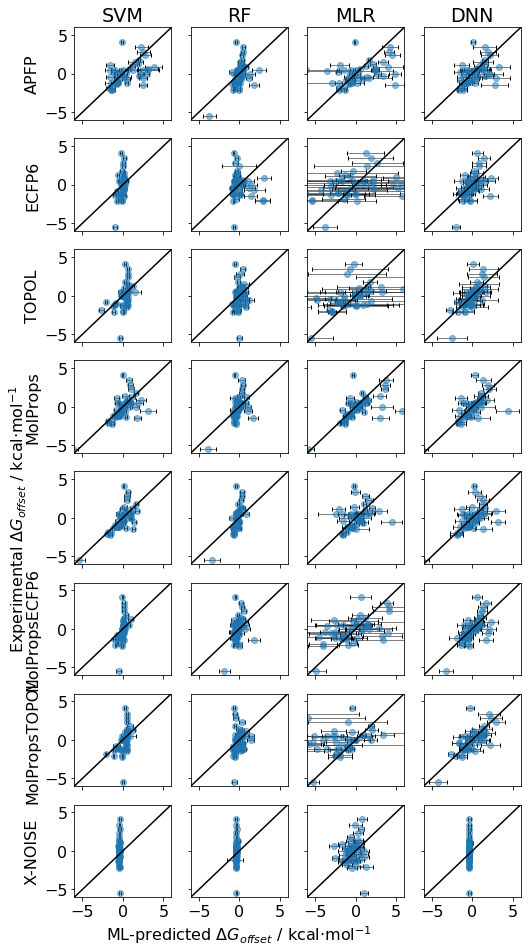

In [11]:
# first plot dGoffset scatterplots (predicted vs exp):
# ML_models = ["SVM"]
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]

data_iterator = []
for feature_set in feature_sets:
    for ml_model in ML_models:
        data_iterator.append([feature_set, ml_model])
        
  
fig, axes = plt.subplots(8, 4, sharey=True, sharex=True, figsize=[8, 16])

# do some formatting on the axes:
for ax, ml_model in zip(axes.flat[0:4], ML_models):
    ax.set_title(ml_model)
    
subplots_for_ylabel = [0, 4, 8, 12, 16, 20, 24, 28]    
for ax, feature_set in zip(axes.flat[subplots_for_ylabel], feature_sets):
    ax.set_ylabel(feature_set)
      
# use the data selection nested list to loop over a flat array of axes:
for ax, data_selection in zip(axes.flat, data_iterator):

    feature_set = data_selection[0]
    ml_model = data_selection[1]
    # load the corresponding test set files (i.e. with the right features)
    test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()
    test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()
    

    # now load both the null and corrector models for this feature set:
    model_output_path = ml_model+"/output/"+feature_set
    all_trained_models = glob.glob(model_output_path+"/*.pickle")
    corrector_models = [model for model in all_trained_models if not "null" in model]

    # now for each model, load and predict; extract the necessary data:

    predictions = []
    for path in corrector_models:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)

    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)

    ax.scatter(mean_predictions, test_y["dGoffset (kcal/mol)"].values, label=feature_set, alpha=0.5)
    ax.errorbar(x=mean_predictions, y=test_y["dGoffset (kcal/mol)"].values, 
             xerr=std_predictions, 
             ls='none', c="black", capsize=2, lw=0.5, zorder=-100)
    ax.plot((-100, 100),(-100, 100),color="black")
    ax.set_ylim(-6,6)
    ax.set_xlim(-6,6)
    
axes.flat[29].set_xlabel(r"ML-predicted $\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")
axes.flat[16].set_ylabel(r"Experimental $\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$", labelpad=15)

plt.rcParams.update({'font.size': 18})

plt.savefig("OUTPUTS/sampl4_offset_predictions_ALL.png", dpi=300)

plt.show()

47


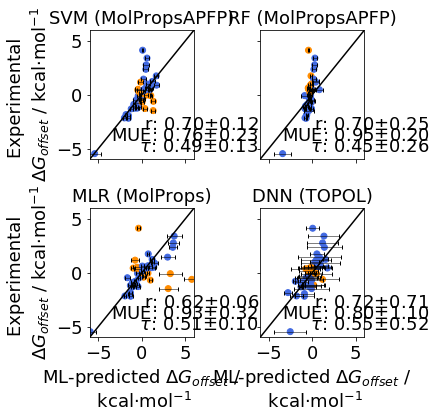

In [12]:
# now make plots of only the top performers to put in main text:

# retrieve data for plotting:
wymer_predictions = test_calc
wymer_uncertainties = test_calc_u
exp_values = test_exp
exp_uncertainties = test_exp_u
print(len(wymer_predictions))
# we want to make a scatterplot for each ML model with overlays of corrected and null predictions:
fig, axes = plt.subplots(2, 2, sharey=True,sharex=True, figsize=[6, 6])


# join the data together with the axes, plot per ml model:

for corrector, null, ax in zip(top_performers_collection, null_top_performers_collection, axes.flat):

    model_name = corrector[0]
    feature_set = corrector[1]

    corrected_predictions = corrector[2][0]
    corrected_uncertainties = corrector[2][1]
    
    ax.set_title(model_name+" ("+feature_set+")", fontsize="medium")
    predicted_dGoffsets = []
    exp_dGoffsets = []
    
    # now extract the corrections:
    colours = []
    for corrected, fep, exp in zip(corrected_predictions, wymer_predictions, exp_values):
        
        # compute the subtracted offset (i.e. the correction that was applied):
        predicted_offset =  corrected - fep
        predicted_dGoffsets.append(predicted_offset)
        # compute the real offset (that we were trying to predict):
        fep_real_offset = exp - fep
        exp_dGoffsets.append(fep_real_offset)
        # derive colours; if both predicted and exp offset are positive or negative, we have a proper direction, if not it's improper:
        if predicted_offset > 0 and fep_real_offset > 0:
            colours.append("royalblue")
        elif predicted_offset < 0 and fep_real_offset < 0:
            colours.append("royalblue")
        else:
            colours.append("darkorange")
        
    ax.scatter(predicted_dGoffsets, exp_dGoffsets, color=colours)
    ax.plot((-100, 100),(-100, 100),color="black")
    ax.errorbar(predicted_dGoffsets, exp_dGoffsets, xerr=corrected_uncertainties, ls="none", color="black", zorder=100, capsize=2, lw=0.5)
    ax.set_ylim(-6,6)
    ax.set_xlim(-6,6)
    # finally, compute stats:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(predicted_dGoffsets, exp_dGoffsets, corrected_uncertainties)
    r = format(r, '.2f')
    mue = format(mue, '.2f')
    tau = format(tau, '.2f')
    r_range = format(r_range, '.2f')
    mue_range = format(mue_range, '.2f')
    tau_range = format(tau_range, '.2f')
    
    ax.annotate(s="      r: "+str(r)+r"$\pm$"+str(r_range), xy=(-3.7,-3.3))
    ax.annotate(s="MUE: "+str(mue)+r"$\pm$"+str(mue_range), xy=(-3.5,-4.3))
    ax.annotate(s=r"     $\tau$: "+str(tau)+r"$\pm$"+str(tau_range), xy=(-3.5,-5.3))
    
    
axes[0][0].set_ylabel("Experimental \n$\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel("Experimental \n$\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")

axes[1][0].set_xlabel("ML-predicted $\Delta G_{offset}$ / \n kcal$\cdot$mol$^{-1}$")
axes[1][1].set_xlabel("ML-predicted $\Delta G_{offset}$ / \n kcal$\cdot$mol$^{-1}$")


plt.rcParams.update({'font.size': 14}) 
    
    
plt.tight_layout()


plt.savefig("OUTPUTS/sampl4_offset_predictions_topperformers.png", dpi=300)
plt.show()

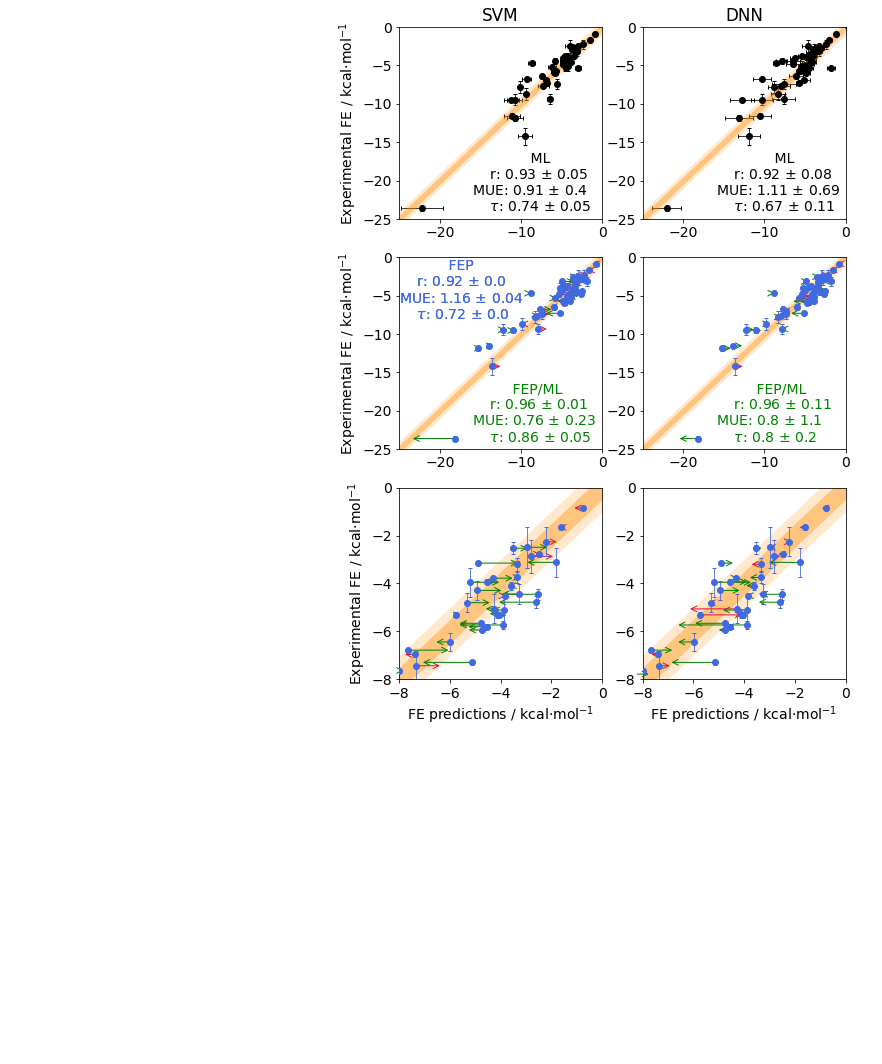

In [13]:
# we want to make a scatterplot for each ML model with overlays of corrected and null predictions:
fig, axes = plt.subplots(3, 2, figsize=[8, 12])

# plot only SVM and DNN:
top_performers_collection_selection = [top_performers_collection[0], top_performers_collection[3]]
null_top_performers_collection_selection = [null_top_performers_collection[0], null_top_performers_collection[3]]

# join the data together with the axes, plot per ml model:
for corrector, null, col in zip(top_performers_collection_selection, null_top_performers_collection_selection, [0, 1]):
    model_name = null[0]
    feature_set_null = null[1]
    predictions_null = null[2][0]
    uncertainties_null = null[2][1]
    corrected_predictions = corrector[2][0]
    corrected_uncertainties = corrector[2][1]
    
    ###########################
    # first, plot the null predictions on the first column:
    axes[0][col].scatter(predictions_null, exp_values, color="black")
    axes[0][col].errorbar(predictions_null, exp_values, 
                xerr=uncertainties_null, yerr=exp_uncertainties, 
                color="black", ls='none', capsize=2, lw=0.8, zorder=-100)
    axes[0][col].set_xlim(-25,0)
    axes[0][col].set_ylim(-25,0)
    # compute stats for ML and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(predictions_null, exp_values, uncertainties_null)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "             ML\n"+r_string + "\n" + mue_string + "\n" + tau_string
    axes[0][col].annotate(s=stats_string, xy=(-16,-24))
    ############################
    # now plot the FEP predictions on the second column:
    def plot_scatter_with_arrow_corrections(row, lower_bound):
        axes[row][col].scatter(wymer_predictions, exp_values, color="royalblue", zorder=200)
        axes[row][col].errorbar(wymer_predictions, exp_values, 
                    xerr=wymer_uncertainties, yerr=exp_uncertainties, 
                    color="royalblue", ls='none', capsize=2, lw=0.8, zorder=200)

        # now plot the corrections. First, extract the actual correction values:
        for corrected, fep, exp in zip(corrected_predictions, wymer_predictions, exp_values):

            # compute the remaining offset after correction:
            corrected_offset = exp - corrected
            # compute the real offset (that we were trying to predict):
            fep_real_offset = fep - exp

            # if the remaining offset is smaller than the real offset, the correction has been beneficial:
            if abs(corrected_offset) <= abs(fep_real_offset):
                line_color = "green"
            else:
                line_color = "crimson"

            # exclude small corrections for formatting:
            if abs(corrected) >= 0.1:
                # draw the arrows:
                axes[row][col].annotate("", xytext=(fep, exp), xy=(corrected, exp), 
                    arrowprops=dict(arrowstyle="->", color=line_color, label="Correction")
                    )
        axes[row][col].set_xlim(lower_bound,0)
        axes[row][col].set_ylim(lower_bound,0)
    plot_scatter_with_arrow_corrections(row=1, lower_bound=-25)
    # compute stats for FEP and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(wymer_predictions, exp_values, wymer_uncertainties)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "           FEP\n" +r_string + "\n" + mue_string + "\n" + tau_string
    axes[1][0].annotate(s=stats_string, xy=(-25,-8), color="royalblue")
    # compute stats for FEP/ML and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(corrected_predictions, exp_values, corrected_uncertainties)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "         FEP/ML\n"+r_string + "\n" + mue_string + "\n" + tau_string
    axes[1][col].annotate(s=stats_string, xy=(-16,-24), color="green")
    ############################
    # now plot the FEP predictions again but zoomed in on the third column:    
    plot_scatter_with_arrow_corrections(row=2, lower_bound=-8)

    
  
# do some formatting on the axes:
for i, ax in enumerate(fig.axes):
    ax.set_xlabel(r"FE predictions / kcal$\cdot$mol$^{-1}$")
    
    ax.fill_between(
				x=[-25, 0], 
				y2=[-24.5,0.5],
				y1=[-25.5,-0.5],
				lw=0, 
				zorder=-10,
				alpha=0.5,
				color="darkorange")
    # upper bound:
    ax.fill_between(
				x=[-25, 0], 
				y2=[-24,1],
				y1=[-24.5,0.5],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
    # lower bound:
    ax.fill_between(
				x=[-25, 0], 
				y2=[-25.5,-0.5],
				y1=[-26,-1],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
    
    
axes[0][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")
axes[2][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")

axes[0][0].set_xlabel("")
axes[0][1].set_xlabel("")
axes[1][0].set_xlabel("")
axes[1][1].set_xlabel("")

axes[0][0].set_title("SVM")
axes[0][1].set_title("DNN")



plt.rcParams.update({'font.size': 14})
plt.savefig("OUTPUTS/sampl4_correction_scatterplots.png", dpi=300)



plt.show()

The outlier (mobley_4587267, ~-23 kcal/mol) seems to influence model performance substancially. Let's regenerate the performance table while excluding this datapoint:

In [14]:
def loadPredictModels(model_paths, test_X, test_y, corrector=False):
    # loads a list of models (using paths), predicts on test set and generates stats for the ensemble.
    
    # adjust test set structure:
    test_y = [ value[0] for value in test_y.values ] 
       
    # loop over model paths, regenerate, predict:
    predictions = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)
    
    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)
    
    if corrector:
        stats, mean_predictions, std_predictions = correctWymer(mean_predictions, std_predictions, test_calc.drop("mobley_4587267"), test_calc_u.drop("mobley_4587267"), test_exp.drop("mobley_4587267"))
    elif not corrector:
        stats = compute_stats_range(mean_predictions, test_y, std_predictions)

    return stats, [mean_predictions, std_predictions]


datasets_dr = "./datasets/DATASETS/"
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]


statistics_collection_no_outlier = []
top_performers_collection_no_outlier = []
null_top_performers_collection_no_outlier = []


for ml_model in ML_models:
    
    top_performer_mue = np.inf
    null_top_performer_mue = np.inf
    
    for feature_set in feature_sets:
        # load the corresponding test set files (i.e. with the right features)
        test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index().drop("mobley_4587267")
        test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index().drop("mobley_4587267")
                
        
        test_X_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index().drop("mobley_4587267")
        test_y_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index().drop("mobley_4587267")
        
        
        # now load both the null and corrector models for this feature set:
        model_output_path = ml_model+"/output/"+feature_set
        all_trained_models = glob.glob(model_output_path+"/*.pickle")
        null_models = [model for model in all_trained_models if "null" in model]
        corrector_models = [model for model in all_trained_models if not "null" in model]
        if len(null_models) != len(corrector_models):
            print("NOT THE SAME NUMBER OF CORRECTOR AND NULL MODELS")
        # we will consider all models equal in the ensemble, so each ensemble consists of 5x10 = 50 trained models.
        
        # now for each model, load and predict; extract the necessary data:
        
        stats, prediction = loadPredictModels(corrector_models, test_X, test_y, corrector=True)
        if stats[1] < top_performer_mue:
            top_performer_mue = stats[1]
            top_performer_predictions = prediction
            top_performer_info = feature_set
        
        stats_null, prediction_null = loadPredictModels(null_models, test_X_null, test_y_null)
        if stats_null[1] < null_top_performer_mue:
            null_top_performer_mue = stats_null[1]
            null_top_performer_predictions = prediction_null
            null_top_performer_info = feature_set
            
        statistics_collection_no_outlier.append([ml_model, feature_set, "Corrector", stats])
        statistics_collection_no_outlier.append([ml_model, feature_set, "Null", stats_null])
    # now for this ML model, extract the top performer and its details:
    top_performers_collection_no_outlier.append([ml_model, top_performer_info, top_performer_predictions])
    null_top_performers_collection_no_outlier.append([ml_model, null_top_performer_info, null_top_performer_predictions])
    
# retrieve original FEP statistics to include as first row in table:
wymer_stats_no = statistics_wymer_df_no.values

stats_df = pd.DataFrame.from_dict([{
        "Model" : "FEP",
        "Featureset" : "",
        "Type" : "",
        "Pearson r" : return_merged_w_pm(wymer_stats_no[0][0], wymer_stats_no[0][1]),
        "MUE" : return_merged_w_pm(wymer_stats_no[1][0], wymer_stats_no[1][1]),
        "RMSE" : return_merged_w_pm(wymer_stats_no[2][0], wymer_stats_no[2][1]),
        "Spearman rho" : return_merged_w_pm(wymer_stats_no[3][0], wymer_stats_no[3][1]),
        "Kendall tau" : return_merged_w_pm(wymer_stats_no[4][0], wymer_stats_no[4][1]),
    }])           

for model in statistics_collection_no_outlier:
    
    model_stats_dict = {
        "Model" : model[0],
        "Featureset" : model[1],
        "Type" : model[2],
        "Pearson r" : return_merged_w_pm(model[3][0], model[3][5]),
        "MUE" : return_merged_w_pm(model[3][1], model[3][6]),
        "RMSE" : return_merged_w_pm(model[3][2], model[3][7]),
        "Spearman rho" : return_merged_w_pm(model[3][3], model[3][8]),
        "Kendall tau" : return_merged_w_pm(model[3][4], model[3][9]),
        "MUE_means" : model[3][1]
    }

    stats_df = stats_df.append(model_stats_dict, ignore_index=True)

    
pd.options.display.max_rows = 999
stats_df = round(stats_df.sort_values(by=["Type", "MUE_means"]), 3).drop("MUE_means", axis=1)
stats_df.to_csv("OUTPUTS/SAMPL4_predictions_statistics_no_outlier.csv")
stats_df

,Model,Featureset,Type,Pearson r,MUE,RMSE,Spearman rho,Kendall tau
0,FEP,,,0.92±0.0,1.07±0.04,1.9±-0.49,0.86±0.0,0.71±0.0
53,DNN,TOPOL,Corrector,0.94±0.12,0.75±1.09,1.07±1.03,0.92±0.17,0.79±0.21
9,SVM,MolPropsAPFP,Corrector,0.94±0.01,0.78±0.22,1.31±0.0,0.95±0.02,0.86±0.05
61,DNN,MolPropsTOPOL,Corrector,0.93±0.08,0.79±0.7,1.21±0.54,0.94±0.09,0.81±0.14
55,DNN,MolProps,Corrector,0.91±0.07,0.8±0.56,1.58±0.22,0.95±0.06,0.83±0.11
13,SVM,MolPropsTOPOL,Corrector,0.94±0.01,0.83±0.13,1.38±-0.11,0.92±0.02,0.78±0.03
59,DNN,MolPropsECFP6,Corrector,0.93±0.06,0.83±0.58,1.31±0.34,0.94±0.12,0.81±0.15
7,SVM,MolProps,Corrector,0.91±0.03,0.87±0.23,1.68±-0.15,0.94±0.01,0.82±0.03
11,SVM,MolPropsECFP6,Corrector,0.94±0.01,0.9±0.14,1.54±-0.2,0.9±0.02,0.76±0.02
5,SVM,TOPOL,Corrector,0.93±0.01,0.9±0.16,1.53±-0.16,0.9±0.03,0.74±0.04


### Insert best ML models into SAMPL4 challenge

In [15]:
def computeTopPerformerStats(collection, entry_name, includes_outlier=True):
    # compute stats in the SAMPL4 format for a given nested list of model predictions.
    collection_sampl4_stats = pd.DataFrame()
    for ml_model_collection in collection:
        ml_model = ml_model_collection[0]
        top_performer_featureset = ml_model_collection[1]
        top_performer_predictions = ml_model_collection[2][0]
        top_performer_uncertainties = ml_model_collection[2][1]
        
        # retrieve the test set of correct size (i.e. with or without the outlier)
        if includes_outlier:
            experimental_values = exp_values
        elif not includes_outlier:
            experimental_values = test_exp
       
        # now compute the stats:
        r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = \
        compute_stats_range(top_performer_predictions, experimental_values, top_performer_uncertainties)
        
        entry = pd.DataFrame({
                    "R" : r,
                    "error4" : r_range,
    
                    "AUE" : mue,
                    "error2" : mue_range,
    
                    "RMS" : rmse,
                    "error1" : rmse_range,
    
                    "tau" : tau,
                    "error3" : tau_range,

                    }, index=[entry_name+ml_model])
        collection_sampl4_stats = collection_sampl4_stats.append(entry)
    # only pass the top performing ML model:
    collection_sampl4_stats = collection_sampl4_stats.sort_values(by="AUE").head(1)
      
    
    return collection_sampl4_stats

In [36]:
# first, grab the SAMPL4 competition data:
sampl4_df = pd.read_csv('./datasets/backend/table_3.csv', dtype={'ID':str})
sampl4_df = sampl4_df.set_index("ID")

# remove DNN because uncertainties are too high:
top_performers_collection = [entry for entry in top_performers_collection if entry[0] != "DNN"]
null_top_performers_collection = [entry for entry in null_top_performers_collection if entry[0] != "DNN"]
top_performers_collection_no_outlier = [entry for entry in top_performers_collection_no_outlier if entry[0] != "DNN"]
null_top_performers_collection_no_outlier = [entry for entry in null_top_performers_collection_no_outlier if entry[0] != "DNN"]

# now compute statistics in the right format; append to sampl4 stats:
top_performers_df = computeTopPerformerStats(top_performers_collection, entry_name="004+")
null_top_performers_df = computeTopPerformerStats(null_top_performers_collection, entry_name="")
# top_performers_no_outlier_df = computeTopPerformerStats(top_performers_collection_no_outlier, entry_name="*004+", includes_outlier=False)
# null_top_performers_no_outlier_df = computeTopPerformerStats(null_top_performers_collection_no_outlier, entry_name="*Null ", includes_outlier=False)
sampl4_df = sampl4_df.append(([
    top_performers_df, 
    null_top_performers_df, 
#     top_performers_no_outlier_df, 
#     null_top_performers_no_outlier_df
    ]), sort=False)

# finally, replace entry 004 statistics with the statistics based on the predictions that we have. It seems that the SAMPL4 
# submission for entry 004 is a different replicate as the predictions in FreeSolv. Stick with the latter instead:


sampl4_df.drop("004", inplace=True)
entry_004_insertion = pd.DataFrame({"RMS" : statistics_wymer_df["Value"].values[2],
                      "error1" : statistics_wymer_df["Uncertainty"].values[2],
                      "AUE" : statistics_wymer_df["Value"].values[1],
                      "error2" : statistics_wymer_df["Uncertainty"].values[1],
                      "tau" : statistics_wymer_df["Value"].values[4],
                      "error3" : statistics_wymer_df["Uncertainty"].values[4],
                      "R" : statistics_wymer_df["Value"].values[0],
                      "error4" : statistics_wymer_df["Uncertainty"].values[0]}, index=["004"])

sampl4_df = sampl4_df.append(entry_004_insertion)

/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


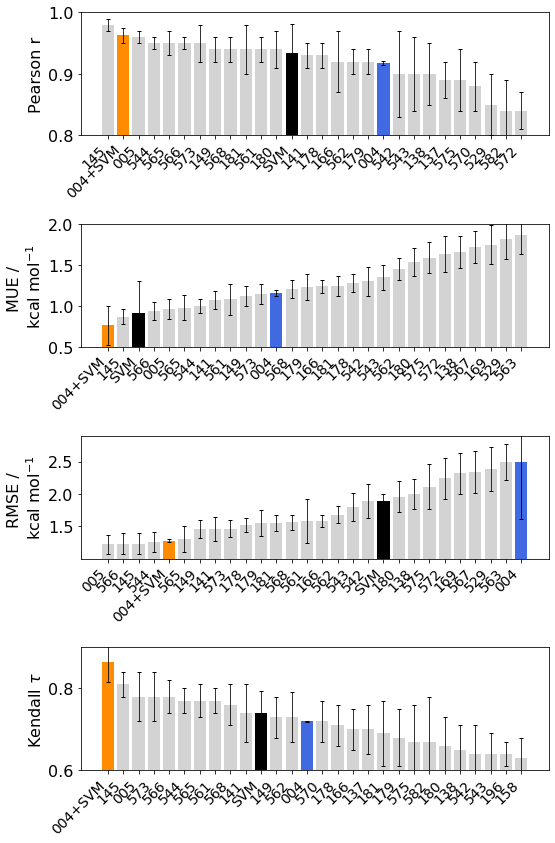

In [44]:

########################################
# construct the graph:
fig, axes = plt.subplots(4, 1, figsize=[8, 12])
num_entries_to_show = 28
plt.rcParams.update({'font.size': 16})

for ax, metric in zip(axes, ["R", "AUE", "RMS", "tau"]):
    # first, select the right subplot:

    
    # the four metrics require different formatting:
    if metric == "AUE":
        # grab the data for this metric and sort:
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=True)
        # grab the uncertainties:
        metric_data_uncertainties = metric_data_sorted["error2"].head(num_entries_to_show).values
        # change the title:
        title = "MUE / \nkcal mol$^{-1}$"
        ax.set_ylim(0.5,2)
    if metric == "RMS":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=True)
        metric_data_uncertainties = metric_data_sorted["error1"].head(num_entries_to_show).values
        title = "RMSE / \nkcal mol$^{-1}$"
        ax.set_ylim(1.001,2.9)
    if metric == "tau":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=False)
        metric_data_uncertainties = metric_data_sorted["error3"].head(num_entries_to_show).values
        title = r"Kendall $\tau$"
        ax.set_ylim(0.6,0.9)
    if metric == "R":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=False)
        metric_data_uncertainties = metric_data_sorted["error4"].head(num_entries_to_show).values
        title = "Pearson r"
        ax.set_ylim(0.8,1)
    
    # extract the actual datapoints we need and their index names (i.e. entries):
    metric_data_values = metric_data_sorted[metric].head(num_entries_to_show).values
    metric_data_indices = metric_data_sorted.head(num_entries_to_show).index.tolist()
    

    # set bar colours:
    index_colours = []
    for entry in metric_data_indices:
            
        if entry == "004+SVM":
            index_colours.append("darkorange")
        elif entry == "SVM":
            index_colours.append("black")
        elif entry == "004":
            index_colours.append("royalblue")

            
        # make all other SAMPL4 entries grey:
        else:
            index_colours.append("lightgrey")

    # make the bars + uncertainties:
    ax.bar(
                x=metric_data_indices, 
                height=metric_data_values, 
                color=index_colours
            )
    ax.errorbar(x=metric_data_indices, y=metric_data_values, yerr=metric_data_uncertainties, 
                fmt="none", capsize=2, lw=0.8, zorder=200, color="black")
    
    
    # some general formatting:
    ax.set_xticklabels(labels=metric_data_indices, rotation=45, ha="right")
    ax.set_ylabel(title)
    for label in (ax.get_xticklabels()):
        label.set_fontsize(14)

        
# fep_patch = mpatches.Patch(color='black', label='Pure FEP')

# hyb_patch = mpatches.Patch(color='lightblue', label='ML+FEP Hybrid')
# null_path = mpatches.Patch(color='darkorange', label='Pure ML')

# # hyb_NO_patch = mpatches.Patch(color='lightblue', label='ML+FEP Hybrid*')
# # null_NO_path = mpatches.Patch(color='navy', label='Null (ML)*')

# axes[0][0].legend(handles=[fep_patch, hyb_patch, null_path], 
#            fontsize="large", loc="upper left")



plt.tight_layout()
plt.savefig("OUTPUTS/sampl4_barplots.png", dpi=300)

In [38]:
sampl4_df

,AUE,Avg. err.,Err. slope,Max. err.,R,RMS,error,error1,error2,error3,error4,error5,error6,tau
005,0.960000,-0.42,1.06,1.81,0.960000,1.220000,0.18,0.150000,0.120000,0.060000,0.010000,0.05,0.67,0.780000
014,1.900000,1.11,1.01,10.69,0.710000,3.070000,0.57,0.720000,0.510000,0.150000,0.260000,0.10,0.70,0.360000
015,2.020000,1.02,1.00,10.37,0.650000,3.090000,0.49,0.460000,0.340000,0.090000,0.200000,0.07,0.42,0.360000
137,2.480000,2.24,0.70,8.38,0.890000,2.890000,0.23,0.300000,0.200000,0.060000,0.030000,0.08,0.50,0.700000
138,1.660000,0.51,0.57,5.25,0.900000,2.000000,0.29,0.230000,0.200000,0.060000,0.050000,0.08,0.23,0.650000
141,1.070000,-0.07,0.72,6.02,0.930000,1.460000,0.28,0.180000,0.110000,0.070000,0.020000,0.08,0.46,0.740000
145,0.870000,-0.44,0.86,1.24,0.980000,1.230000,0.16,0.160000,0.090000,0.030000,0.010000,0.08,0.89,0.810000
149,1.120000,0.03,0.55,2.74,0.940000,1.460000,0.24,0.140000,0.120000,0.050000,0.020000,0.04,0.89,0.730000
152,4.050000,-3.48,0.31,3.93,0.570000,5.520000,0.98,1.250000,0.850000,0.080000,0.170000,0.06,3.84,0.390000
153,3.070000,-2.35,0.57,2.95,0.750000,3.950000,0.52,0.400000,0.410000,0.040000,0.100000,0.06,0.77,0.490000


## Apply correction term to all published SAMPL4 entries

In [19]:
svm_hybrid_predictions = top_performers_collection[0][2][0]

fep_predictions = test_calc.values
smiles_per_freesolv_entry = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','SMILES']
# now add the six discrepant molecules to the test set:
dscrpnt_mols = ['mobley_6309289', 'mobley_3395921', 'mobley_6739648', 'mobley_2607611', 'mobley_637522', 'mobley_172879']
for mol in dscrpnt_mols:
    mol_info = freesolv_df.loc[freesolv_df.index == mol]
    smiles_per_freesolv_entry = smiles_per_freesolv_entry.append(mol_info['SMILES'])
smiles_per_freesolv_entry = smiles_per_freesolv_entry.sort_index()

svm_offset_predictions = (svm_hybrid_predictions-fep_predictions).tolist()

freesolv_ids = pd.DataFrame({
    "FREESOLV_ID" : test_calc.index,
    "offset_pred" : svm_offset_predictions,
    "dG_exp" : test_exp.values,
    "SMILES" : smiles_per_freesolv_entry.values
}).set_index("SMILES")

sampl4_ids = pd.read_csv("datasets/backend/title_vs_smiles_sampl4.txt", header=None, sep="    ", engine='python')
sampl4_ids.columns = ["SAMPL4_ID", "SMILES"]
sampl4_ids = sampl4_ids.set_index("SMILES")

corrector_df = pd.concat([sampl4_ids, freesolv_ids], axis=1, sort=True).dropna().reset_index().drop("index", axis=1)
corrector_df = corrector_df.set_index("SAMPL4_ID")

In [20]:
# now generate an iterable for all sampl4 submissions:
submissions_path = "./datasets/backend/sampl4_submissions/"
submissions_dir = glob.glob(submissions_path+"*")
# clean file names:
submissions_dir = [file.replace(submissions_path, "") for file in submissions_dir]
# take only the .data files:
submissions_dir = [file for file in submissions_dir if file.endswith(".data")]

# loop over submissions, compute statistics with and without correcting:
processed_entries = []

# read per file:
stats_collection = []
entry_names_collection = []
for filepath in submissions_dir:
    entry_name = filepath.split(".")[0]
    if not entry_name == "580":    # this entry only has 11 computed energies; discard.
        
        entry_df = pd.read_csv(submissions_path+filepath, comment="#", header=None, usecols=[0,1])
        entry_df.columns = ["SAMPL4_ID", "FE_pred"]
        entry_df = entry_df.set_index("SAMPL4_ID")

        # construct a dataframe with the respective corrections:
        collected_df = pd.concat([corrector_df, entry_df], axis=1, sort=True).dropna()

        # compute the hybrid predictions for this entry:
        collected_df["FE_hyb"] = collected_df["FE_pred"] + collected_df["offset_pred"] 
        
        # now compute stats for standalone and hybridised version of this entry:
        stats_standalone = compute_stats( collected_df["FE_pred"],  collected_df["dG_exp"])
        stats_hybrid = compute_stats(collected_df["FE_hyb"],  collected_df["dG_exp"])
 
        stats_improvements_this_entry = list(zip(stats_hybrid, stats_standalone))
        stats_collection.append(stats_improvements_this_entry)
        entry_names_collection.append(entry_name)
        # if we need revert back to % gain per statistic, compute % gain here and skip next code block.

In [21]:
# using this data, compute original ranking per metric and number of ranks gained (or lost) by correction:
def compute_hybrid_rank_gain(statistic_dataframe, error_metric):
    """
    computes both the standalone SAMPL4 rank for this statistic as well as the hybrid rank when inserted into
    the standalone entries.
    """
    records_df = pd.DataFrame.from_records(statistic_dataframe, columns=["hybrid", "standalone"])
    records_df["entry_name"] = entry_names_collection
    records_df = records_df.sort_values(by="standalone", ascending=error_metric).reset_index()

    # compute standalone ranking:
    records_df["standalone_rank"] = records_df.index.values + 1

    # compute hybrid ranking:

    hybrid_ranks = []
    for idx, row in records_df.iterrows():
        hybrid_value = row["hybrid"]
        entry_name = row["entry_name"]
        # now figure out at what rank this hybrid statistic would place in the standalone ranking:
        # drop the standalone entry:
        inserted_df = records_df.loc[records_df["entry_name"] != entry_name]


        inserted_df = inserted_df.append({"entry_name" : "insert",
                                "standalone" : hybrid_value}, ignore_index=True).sort_values(
                                    by="standalone", ascending=error_metric).reset_index()
        hybrid_rank = inserted_df.loc[inserted_df["entry_name"] == "insert"].index.values + 1


        hybrid_ranks.append(int(hybrid_rank))

    records_df["hybrid_rank"] = hybrid_ranks
    records_df["rank_gain"] = records_df["standalone_rank"] - records_df["hybrid_rank"]
    records_df = records_df.set_index("entry_name")

    return records_df["rank_gain"], records_df["standalone_rank"]


r_vals = [entry_data[0] for entry_data in stats_collection]
r_gains, r_ranks = compute_hybrid_rank_gain(r_vals, error_metric=False)

mue_vals = [entry_data[1] for entry_data in stats_collection]
mue_gains, mue_ranks = compute_hybrid_rank_gain(mue_vals, error_metric=True)

rmse_vals = [entry_data[2] for entry_data in stats_collection]
rmse_gains, rmse_ranks = compute_hybrid_rank_gain(rmse_vals, error_metric=True)

rho_vals = [entry_data[3] for entry_data in stats_collection]
rho_gains, rho_ranks = compute_hybrid_rank_gain(rho_vals, error_metric=False)

tau_vals = [entry_data[4] for entry_data in stats_collection]
tau_gains, tau_ranks = compute_hybrid_rank_gain(tau_vals, error_metric=False)

all_stats_gains_df = pd.concat([r_gains, mue_gains, rmse_gains, rho_gains, tau_gains,
                               r_ranks, mue_ranks, rmse_ranks, rho_ranks, tau_ranks], axis=1) 
all_stats_gains_df.columns =[ "r_improvement",
                        "mue_improvement", 
                        "rmse_improvement", 
                        "rho_improvement", 
                        "tau_improvement",
                         "r_ranks",
                        "mue_ranks", 
                        "rmse_ranks", 
                        "rho_ranks", 
                        "tau_ranks",
                        ]
all_stats_gains_df["aggregate"] = all_stats_gains_df["r_improvement"] + all_stats_gains_df["mue_improvement"] + all_stats_gains_df["tau_improvement"]
all_stats_gains_df["aggregate_original"] = all_stats_gains_df["r_ranks"] + all_stats_gains_df["mue_ranks"] + all_stats_gains_df["tau_ranks"]

# compute ranks before and after hybridisation:
all_stats_gains_df["r_before"] = all_stats_gains_df["r_ranks"]
all_stats_gains_df["r_after"] = all_stats_gains_df["r_ranks"] - all_stats_gains_df["r_improvement"]

all_stats_gains_df["mue_before"] = all_stats_gains_df["mue_ranks"]
all_stats_gains_df["mue_after"] = all_stats_gains_df["mue_ranks"] - all_stats_gains_df["mue_improvement"]

all_stats_gains_df["rmse_before"] = all_stats_gains_df["rmse_ranks"]
all_stats_gains_df["rmse_after"] = all_stats_gains_df["rmse_ranks"] - all_stats_gains_df["rmse_improvement"]

all_stats_gains_df["tau_before"] = all_stats_gains_df["tau_ranks"]
all_stats_gains_df["tau_after"] = all_stats_gains_df["tau_ranks"] - all_stats_gains_df["tau_improvement"]

# now drop all redundant columns:
cols_to_drop = ["r_improvement", "mue_improvement", "rmse_improvement", "rho_improvement", "tau_improvement", "r_ranks", "mue_ranks", "rmse_ranks", "rho_ranks", "tau_ranks"]

for col_name in cols_to_drop:
    all_stats_gains_df.drop(col_name, inplace=True, axis=1)

all_stats_gains_df

/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,aggregate,aggregate_original,r_before,r_after,mue_before,mue_after,rmse_before,rmse_after,tau_before,tau_after
004,34,38,14,2,10,1,7,1,14,1
005,-3,8,2,2,4,7,1,7,2,2
006,13,19,8,2,6,2,5,1,5,2
014,-8,126,43,43,34,41,39,41,49,50
015,-1,130,44,44,36,37,40,41,50,50
137,25,85,27,15,42,42,36,32,16,3
138,-5,75,24,24,26,32,24,29,25,24
141,-8,36,17,15,7,10,8,9,12,19
145,-24,3,1,5,1,19,2,24,1,3
149,-6,29,9,13,9,12,9,20,11,10


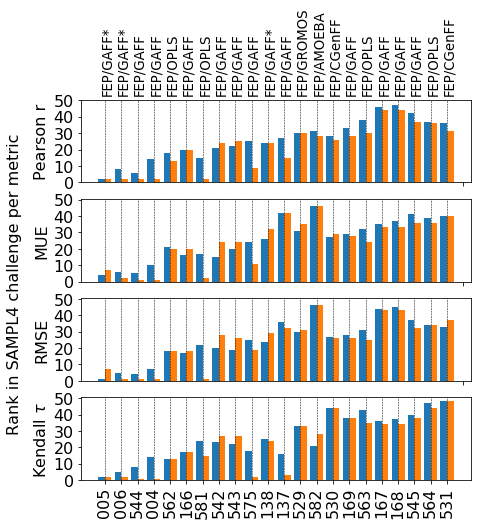

In [22]:
# append information and plot:

sampl4_entries_hybrids = all_stats_gains_df
sampl4_entry_info_records = pd.read_csv("./datasets/backend/sampl4_entries_info.csv", dtype={'Entry': object}).set_index("Entry")
sampl4_entry_info_records = sampl4_entry_info_records["LABEL"]
sampl4_entries_hybrids_unsorted = pd.concat([sampl4_entries_hybrids, sampl4_entry_info_records], axis=1, sort=False).dropna()

# now set up data: we want all FEP entries and the top non-FEP entries:
sampl4_entries_fep = sampl4_entries_hybrids_unsorted[sampl4_entries_hybrids_unsorted["LABEL"].str.contains("FEP")]
sampl4_entries_fep = sampl4_entries_fep.sort_values(by="aggregate_original", ascending=True)

sampl4_entries_top_nonfep = sampl4_entries_hybrids_unsorted[~sampl4_entries_hybrids_unsorted["LABEL"].str.contains("FEP")]
sampl4_entries_top_nonfep = sampl4_entries_top_nonfep.sort_values(by="aggregate_original", ascending=True)


fig, axes = plt.subplots(4, 1, sharey=True, figsize=(7,7))
x_values_fep = sampl4_entries_fep.index.values
x_values_top_nonfep = sampl4_entries_top_nonfep.index.values

bar_width=0.4


axes[0].bar(x_values_fep, sampl4_entries_fep["r_before"], width=-bar_width, align="edge")
axes[0].bar(x_values_fep, sampl4_entries_fep["r_after"], width=bar_width, align="edge")
axes[0].set_xticks("")
axes[0].set_ylabel("Pearson r")

axes[1].bar(x_values_fep, sampl4_entries_fep["mue_before"], width=-bar_width, align="edge")
axes[1].bar(x_values_fep, sampl4_entries_fep["mue_after"], width=bar_width, align="edge")
axes[1].set_xticks("")
axes[1].set_ylabel("MUE")

axes[2].bar(x_values_fep, sampl4_entries_fep["rmse_before"], width=-bar_width, align="edge")
axes[2].bar(x_values_fep, sampl4_entries_fep["rmse_after"], width=bar_width, align="edge")
axes[2].set_xticks("")
axes[2].set_ylabel("RMSE")

axes[3].bar(x_values_fep, sampl4_entries_fep["tau_before"], width=-bar_width, align="edge")
axes[3].bar(x_values_fep, sampl4_entries_fep["tau_after"], width=bar_width, align="edge")
axes[3].set_xticklabels(labels=x_values_fep, rotation=90)
axes[3].set_ylabel(r"Kendall $\tau$")

for ax in axes:
    for x_val in x_values_fep:
        ax.axvline(x_val, color="black", ls="--", lw=0.5)

# now include top tags with methods:

for entry, info in zip(range(len(x_values_fep)), sampl4_entries_fep["LABEL"].values):
    axes[0].text(x=entry-0.3, y=55, s=info, ha="left", rotation=90, size="small")


plt.locator_params(axis='y', nbins=6)
plt.text(s="Rank in SAMPL4 challenge per metric", x=-6, y=30, rotation=90)
plt.savefig("OUTPUTS/translatability_sampl4_barplot.png", dpi=300, bbox_inches="tight")

plt.show()

    


Now generate the same plot but for non-FEP entries

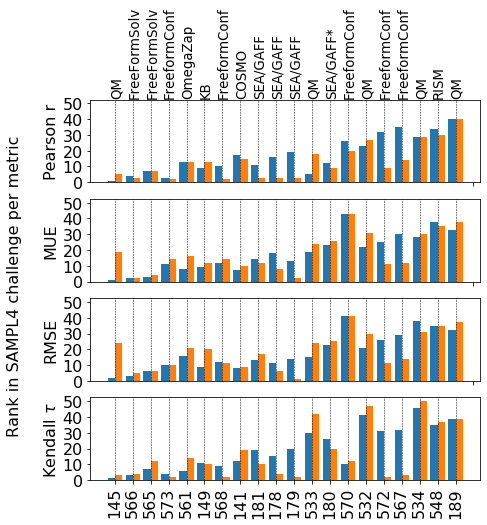

In [23]:
# take only top n entries:
sampl4_entries_top_nonfep = sampl4_entries_top_nonfep.head(20)

fig, axes = plt.subplots(4, 1, sharey=True, figsize=(7,7))
x_values_fep = sampl4_entries_fep.index.values
x_values_top_nonfep = sampl4_entries_top_nonfep.index.values

bar_width=0.4


axes[0].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["r_before"], width=-bar_width, align="edge")
axes[0].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["r_after"], width=bar_width, align="edge")
axes[0].set_xticks("")
axes[0].set_ylabel("Pearson r")

axes[1].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["mue_before"], width=-bar_width, align="edge")
axes[1].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["mue_after"], width=bar_width, align="edge")
axes[1].set_xticks("")
axes[1].set_ylabel("MUE")

axes[2].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["rmse_before"], width=-bar_width, align="edge")
axes[2].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["rmse_after"], width=bar_width, align="edge")
axes[2].set_xticks("")
axes[2].set_ylabel("RMSE")

axes[3].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["tau_before"], width=-bar_width, align="edge")
axes[3].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["tau_after"], width=bar_width, align="edge")
axes[3].set_xticklabels(labels=x_values_top_nonfep, rotation=90)
axes[3].set_ylabel(r"Kendall $\tau$")

for ax in axes:
    for x_val in x_values_top_nonfep:
        ax.axvline(x_val, color="black", ls="--", lw=0.5)

# now include top tags with methods:

for entry, info in zip(range(len(x_values_top_nonfep)), sampl4_entries_top_nonfep["LABEL"].values):
    axes[0].text(x=entry-0.3, y=55, s=info, ha="left", rotation=90, size="small")


plt.locator_params(axis='y', nbins=6)
plt.text(s="Rank in SAMPL4 challenge per metric", x=-6, y=30, rotation=90)
plt.savefig("OUTPUTS/translatability_nonfep_sampl4_barplot.png", dpi=300, bbox_inches="tight")

plt.show()